In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

from casadi import *
from pylab import plot, step, figure, legend, show, spy

opts0 = {"ipopt.linear_solver":'ma27', "ipopt.tol":1e-1, "expand":False,'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}

Running Python: 3.8.16


In [82]:
N = 100 # number of control intervals
opti = Opti() # Optimization problem

R0 = 1  # initial radius
Rf = 1*R0  # initial radius
Mu = 1  # orbit param
V0 = np.sqrt(Mu/R0)
Vf = np.sqrt(Mu/Rf)
X0 = np.pi/10
m0 = 1  # initial fuel
mf = 0.2  # initial fuel
m1 = -0.01 # fuel descrease rate
#print(f'Initial Mass = {m0 :0.3f}')
#print(f'Final Mass = {m0 + m1*Tf:0.3f}')
T = 0.01    # thrust
Tmax = abs((m0-mf)/m1)

In [83]:
# ---- decision variables ---------
X = opti.variable(4,N+1) # state trajectory
orbit_r = X[0,:]
orbit_u = X[1,:]
orbit_v = X[2,:]
orbit_x = X[3,:]  # angle swept in orbit
U = opti.variable(1,N)   # control trajectory (throttle)
Tf = opti.variable()      # final time

opti.minimize(Tf) # race in minimal time

# dx/dt = f(x,u)
f = lambda x,u,t: vertcat(x[1],
                          x[2]**2/x[0] - Mu/x[0]**2 + T*sin(u)/(m0 + m1*t),
                          -x[1]*x[2]/x[0] + T*cos(u)/(m0 + m1*t),
                          x[2]/x[0])  #\dot \theta = v_t/r

dt = Tf/N # length of a control interval
for k in range(N-1): # loop over control intervals
    k1 = f(X[:,k],         U[:,k],k*dt)
    k2 = f(X[:,k]+dt/2*k1, (U[:,k]+U[:,k+1])/2.0,(k+1/2)*dt)
    k3 = f(X[:,k]+dt/2*k2, (U[:,k]+U[:,k+1])/2.0,(k+1/2)*dt)
    k4 = f(X[:,k]+dt*k3,   U[:,k+1],(k+1)*dt)
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
    opti.subject_to(X[:,k+1]==x_next) # close the gaps
else:
    # now do the last step (no u(k+1))
    k = N-1
    k1 = f(X[:,k],         U[:,k],k*dt)
    k2 = f(X[:,k]+dt/2*k1, U[:,k],(k+1/2)*dt)
    k3 = f(X[:,k]+dt/2*k2, U[:,k],(k+1/2)*dt)
    k4 = f(X[:,k]+dt*k3,   U[:,k],(k+1)*dt)
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
    opti.subject_to(X[:,k+1]==x_next) # close the gaps

opti.subject_to(opti.bounded(-np.pi,U,np.pi)) # control is limited

# ---- boundary conditions --------
opti.subject_to(orbit_r[0] == R0)  
opti.subject_to(orbit_u[0] == 0) # 
opti.subject_to(orbit_v[0] == V0) 
opti.subject_to(orbit_x[0] == 0) 
opti.subject_to(orbit_r[-1] == Rf)   
opti.subject_to(orbit_u[-1] == 0) 
opti.subject_to(orbit_v[-1] == Vf) 
opti.subject_to(orbit_x[-1] == X0+Tf*Vf) 

# ---- misc. constraints  ----------
opti.subject_to(Tf > 0) # Time must be positive
opti.subject_to(Tf <= Tmax) # mass must be positive

# ---- initial values for solver ---
opti.set_initial(orbit_r, R0)
opti.set_initial(orbit_u, 0)
opti.set_initial(orbit_v, V0)
opti.set_initial(orbit_x, X0)
opti.set_initial(Tf, Tmax/2)

opts = {"ipopt.linear_solver":'ma27', "ipopt.tol":1e-3, "expand":False, 
        'ipopt.print_level': 3, 'print_time': 1, 'ipopt.sb': 'yes'}
opti.solver('ipopt',opts) # set numerical backend

sol = opti.solve()   # actual solve
sol.value

Total number of variables............................:      505
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:      100
        inequality constraints with only upper bounds:        1


Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:   6.9741585847377765e+00    6.9741585847377765e+00
Dual infeasibility......:   4.3261321984908256e-04    4.3261321984908256e-04
Constraint violation....:   1.6889984117751666e-05    1.6889984117751666e-05
Complementarity.........:   4.1768193218827227e-05    4.1768193218827227e-05
Overall NLP e

<bound method OptiSol.value of OptiSol(Opti {
  instance #13
  #variables: 3 (nx = 505)
  #parameters: 0 (np = 0)
  #constraints: 111 (ng = 510)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})>

In [84]:
r = sol.value(orbit_r)
u = sol.value(orbit_u)
v = sol.value(orbit_v)
x = sol.value(orbit_x)
tf = sol.value(Tf)
t = np.linspace(0,tf,N+1)
phi = sol.value(U)
phi = (phi + np.pi) % (2 * np.pi) - np.pi #https://stackoverflow.com/questions/15927755/opposite-of-numpy-unwrap/15927914

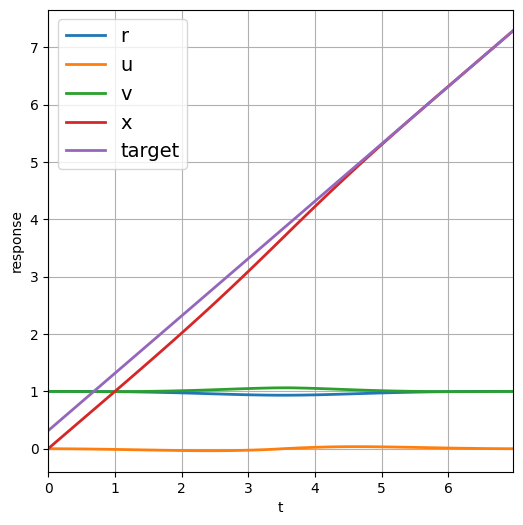

In [85]:
plt.figure(figsize = (6,6))
plt.plot(t,r,label="r")
plt.plot(t,u,label="u")
plt.plot(t,v,label="v")
plt.plot(t,x,label="x")
plt.plot(t,X0+Vf*t,label="target")
plt.legend(loc="upper left")
plt.xlabel('t')
plt.ylabel('response')
plt.legend()
plt.legend(fontsize=14)
plt.xlim([0,tf])
plt.savefig("figs/Orbit_tf_casadi_1.png")
plt.show()

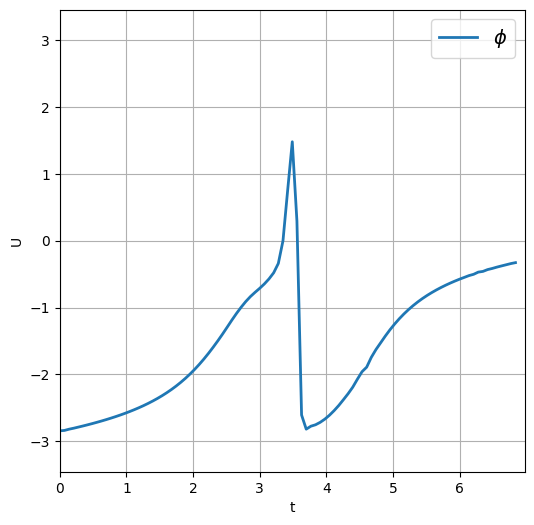

In [86]:
plt.figure(figsize = (6,6))
plt.plot(t[:-2],phi[:-1],label="$\phi$")
plt.legend(loc="upper left")
plt.xlabel('t')
plt.ylabel('U')
plt.legend()
plt.legend(fontsize=14)
plt.xlim([0,tf])
plt.ylim([-1.1*np.pi,1.1*np.pi])
plt.savefig("figs/Orbit_tf_casadi_2.png")
plt.show()

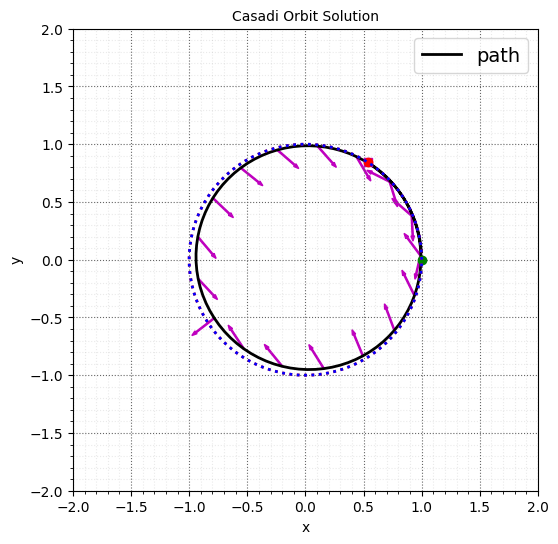

In [87]:
dt = np.diff(t);
dth = (v/r)[:-1]*dt # \dot \theta = v_t/r
th = 0 + np.cumsum(dth)

pathloc = [r[:-1]*np.cos(th), r[:-1]*np.sin(th)];

plt.figure(figsize = (6,6))
plt.plot(pathloc[0],pathloc[1],'k-',label='path')
plt.plot(R0,0,'go') # start
plt.plot(Rf*np.cos(X0+Vf*tf),Rf*np.sin(X0+Vf*tf),'ms') # stop
plt.plot(Rf*np.cos(th[-1]),Rf*np.sin(th[-1]),'ro') # stop

# make an orbit
ang = np.arange(0,2*np.pi-1e-10,.01)
zz = np.exp(complex(0,1)*ang);
plt.plot(R0*zz.real,R0*zz.imag,'r:')
plt.plot(Rf*zz.real,Rf*zz.imag,'b:')

#arrow(x, y, dx, dy, **kwargs)[source]
fact = 0.2
ep = np.pi/2 + th - phi
xt = fact*np.cos(ep)
yt = fact*np.sin(ep)
for i in np.arange(0,th.shape[0],int(0.05*N)):
    plt.arrow(pathloc[0][i],pathloc[1][i],xt[i],yt[i],color='m',width=.01)

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.legend(fontsize=14)
plt.title('Casadi Orbit Solution')
rr = max(math.ceil(Rf+0.5),R0+0.25)
plt.xlim([-rr,rr])
plt.ylim([-rr,rr])
nicegrid()